In [1]:
library(car)
library(effects)
data(mtcars)
mtcars$origin <- c('Other','Other','USA','USA','USA','USA','USA','Other','Other','Other',
                   'Other','Other','Other','Other','USA','USA','USA','Other','Other',
                   'Other','Other','USA','USA','USA','USA','Other','Other','Other',
                   'USA','Other','Other','Other')
mtcars$origin <- as.factor(mtcars$origin)

vs.lab <- rep("",length(mtcars$vs)) 
vs.lab[mtcars$vs == 0] <- "V-shaped"
vs.lab[mtcars$vs == 1] <- "Straight"

mtcars$vs <- as.factor(vs.lab)

Loading required package: carData

lattice theme set by effectsTheme()
See ?effectsTheme for details.



# Higher-order ANOVA II: The Full Factorial Model


So far, we have looked at the additive model that assumes a constant row and column difference between the cell means. However, as alluded to earlier, this additive assumption may not always hold. Indeed, in many real-world examples, we *expect* the factors in the model to influence each other. We saw an example earlier of *depression* and *anxiety*. Another example would be a basic $2 \times 2$ model of a clinical trial. If Factor A is *diagnosis* (*patient*, *control*) and Factor B is *drug* (*placebo*, *medication*), then the expectation might be that the effect of the drug (i.e. *medication vs placebo*) is different depending upon whether you are a *control* or a *patient*. For instance, if the drug is very targeted then there may only be a difference between the medication and a placebo if you are patient, but not if you are a control. In this example, the effect of *drug* depends upon *diagnosis*. When *diagnosis = control* there is no effect, but when *diagnosis = patient* there is an effect. This form of dependence between the levels of multiple factors is known as an *interaction*.

```{admonition} Interaction Definition
:class: tip
Within the context of an ANOVA, the omnibus *interaction* effect of two categorical predictor is defined as the degree to which the effect of one factor (i.e. the difference between its levels) changes depending upon the levels of another factor. When there are two factors involved this is known as a 2-way interaction. This can also be thought of as the degree to which the additivity assumption does not hold, based on comparing the estimated means to the sample means. 
```

## Conceptual Understanding of an Interaction
An interaction can most easily be understood conceptually as a *difference* of a *difference*. Thinking back to our basic $2 \times 2$ arrangement, we have the following means table

|                       | Factor B: Level 1 | Factor B: Level 2 | 
|-----------------------|-------------------|-------------------|
| **Factor A: Level 1** | $\mu_{11}$        | $\mu_{12}$        |
| **Factor B: Level 2** | $\mu_{21}$        | $\mu_{22}$        |

Remember that the additive model assumes a *constant difference* between the columns and the rows, such that the level of the second factor does not change the effect of the first factor. In terms of the cell means, this leads to

$$
\begin{alignat*}{1}
    \text{Factor A} &: \mu_{11} - \mu_{21} = \mu_{12} - \mu_{22} \quad\text{(row effects are the same)} \\
    \text{Factor B} &: \mu_{11} - \mu_{12} = \mu_{21} - \mu_{22} \quad\text{(column effects are the same)} \\
\end{alignat*}
$$

So how would we test whether this is true? Let us rewrite the additive assumption about Factor A a different way

$$
\left(\mu_{11} - \mu_{21}\right) - \left(\mu_{12} - \mu_{22}\right) = 0.
$$

So we can see that the additive assumption says that this *difference* of *differences* is 0. So, in cases where additivity does not hold, we would expect this value to be *non-zero*. Thus, in order to test an interaction, we calculate

$$
\begin{alignat*}{1}
    \text{A $\times$ B} &= \left(\mu_{11} - \mu_{21}\right) - \left(\mu_{12} - \mu_{22}\right) \\
                        &= \mu_{11} - \mu_{21} - \mu_{12} + \mu_{22},
\end{alignat*}
$$

where the second form simply comes from removing the brackets. Of note is that we can also express this in terms of testing the column effects of Factor B

$$
\begin{alignat*}{1}
    \text{B $\times$ A} &= \left(\mu_{11} - \mu_{12}\right) - \left(\mu_{21} - \mu_{22}\right) \\
                        &= \mu_{11} - \mu_{12} - \mu_{21} + \mu_{22},
\end{alignat*}
$$

which is *exactly the same expression*. So, there is only a *single* interaction effect that simultaneously captures both *non-constant row effects* and *non-constant column effects*. 

### Interaction Plots

In [2]:
# ---- Setup ----
set.seed(42)

# Helper: simulate data from a 2x2 means table
sim_2x2 <- function(means, n_per_cell = 30, sd = 2,
                    A_levels = c("A1","A2"), B_levels = c("B1","B2")) {
  stopifnot(all(dim(means) == c(2,2)))
  df <- expand.grid(A = A_levels, B = B_levels)
  df$mean <- c(means[1,1], means[2,1], means[1,2], means[2,2])  # order: (A,B) = (A1,B1),(A2,B1),(A1,B2),(A2,B2)
  dat <- do.call(rbind, lapply(seq_len(nrow(df)), function(i) {
    data.frame(A = df$A[i], B = df$B[i],
               y = rnorm(n_per_cell, mean = df$mean[i], sd = sd))
  }))
  dat$A <- factor(dat$A, A_levels)
  dat$B <- factor(dat$B, B_levels)
  dat
}

# ---- Scenario 1: No interaction (purely additive) ----
# Simple effect of A is +2 at both B levels
means_no_int <- matrix(c(10, 12, 14, 16), nrow = 2, byrow = FALSE)
# rows: A1,A2 ; cols: B1,B2   => A1B1=10, A2B1=12, A1B2=14, A2B2=16
dat_no <- sim_2x2(means_no_int)
#plots_no <- plot_pair(dat_no, "No interaction")

# ---- Scenario 2: Non-crossover interaction ----
# Simple effect of A increases from +2 (at B1) to +6 (at B2)
means_nonx <- matrix(c(10, 12, 11, 17), nrow = 2, byrow = FALSE)
# A1B1=10, A2B1=12, A1B2=11, A2B2=17
dat_nonx <- sim_2x2(means_nonx)
#plots_nonx <- plot_pair(dat_nonx, "Non-crossover interaction")

# ---- Scenario 3: Crossover interaction ----
# Effects reverse sign across B (lines cross)
means_xover <- matrix(c(10, 14, 16, 12), nrow = 2, byrow = FALSE)
# A1B1=10, A2B1=14, A1B2=16, A2B2=12
dat_x <- sim_2x2(means_xover)
#plots_x <- plot_pair(dat_x, "Crossover interaction")


It can be helpful at this stage to visualise what an interaction looks like. In the plots below, the cell means are illustrated for two factors in a $2 \times 2$ design. This form of graph is known as an *interaction plot*. Each cell mean is illustrated as a single point, with lines drawn across the levels of a single factor. In this example, the lines illustrate the differences between Level 1 and 2 of Factor B, with different line types showing this effects at the two levels of Factor A. 

In this first plot, there is *no interaction*. So, this represents the pattern of means when additivity holds. As we can see, there is a constant *horizontal* difference between `B1` and `B2`, irrespective of the level of Factor A. Similarly, there is a constant *vertical* difference between the `A1` and `A2`, irrespective of the level of Factor B. 

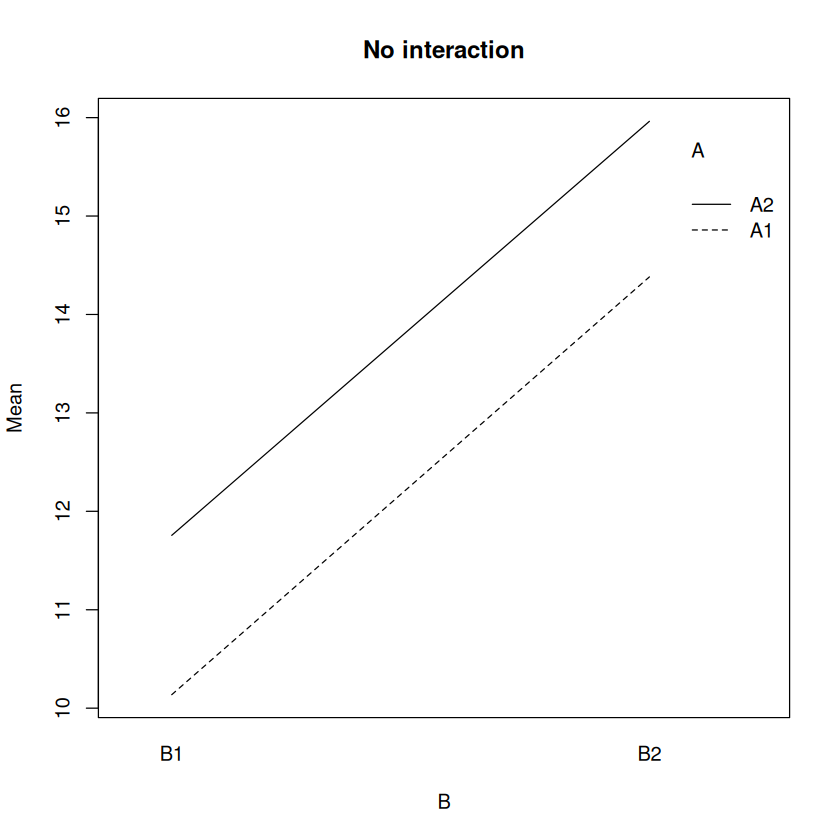

In [3]:
with(dat_no,    interaction.plot(x.factor = B, trace.factor = A, response = y, ylab = "Mean", main = "No interaction"))

In the second plot, we see a *deviation* from parallel lines. This is known as a *non-crossover* interaction because the lines do not cross. This is typical of the type of interaction where the *magnitude* of the effect depends upon the level of one of the factors. For instance, is this were our drug $\times$ diagnosis clinical trial, this sort of pattern could emerge when the drug is *more effective* in the patient group compared to the control group.

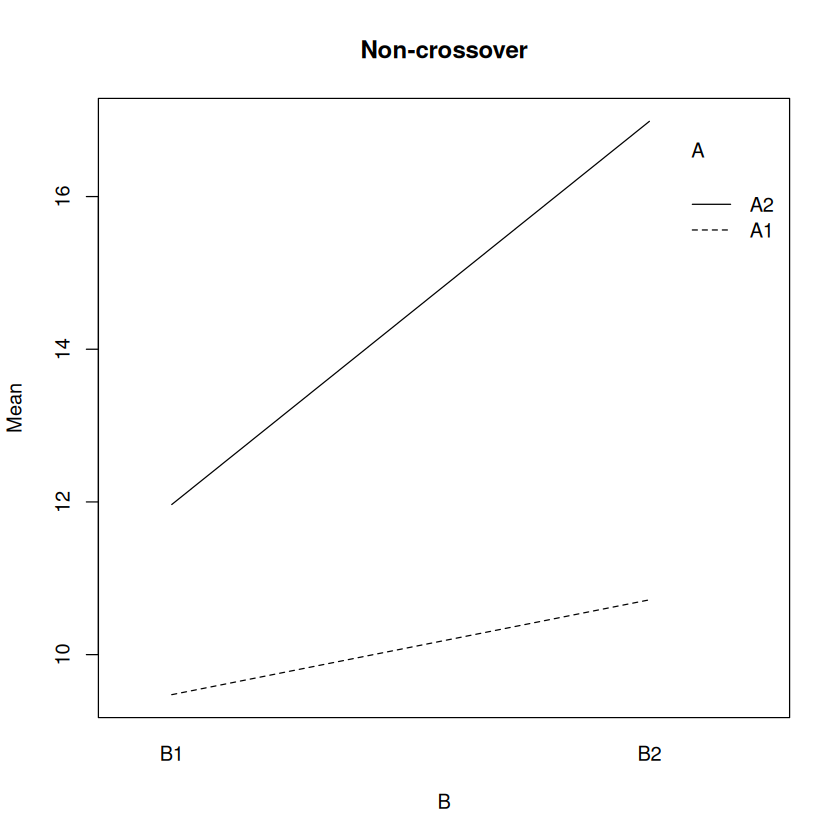

In [4]:
with(dat_nonx,  interaction.plot(x.factor = B, trace.factor = A, response = y, ylab = "Mean", main = "Non-crossover"))

In the final plot, we see a *crossover interaction*, so-called because the lines create an x-shape. This form of interaction can be more unusal as it implies a complete reversal of the effect of one factor at different levels of another. In our clinical trial example, this could imply that the patients *improve* when taking the drug, whereas the controls get *worse*. This is not implausible. Perhaps without any clinical benefit, the side-effects of the drug are more pronounced in the control group. Of note is that we are better powered to detect cross-over interactions compared to non-crossover. This is because the *difference* of *differences* is always larger for a crossover than a non-crossover interaction[^crosspower-foot].

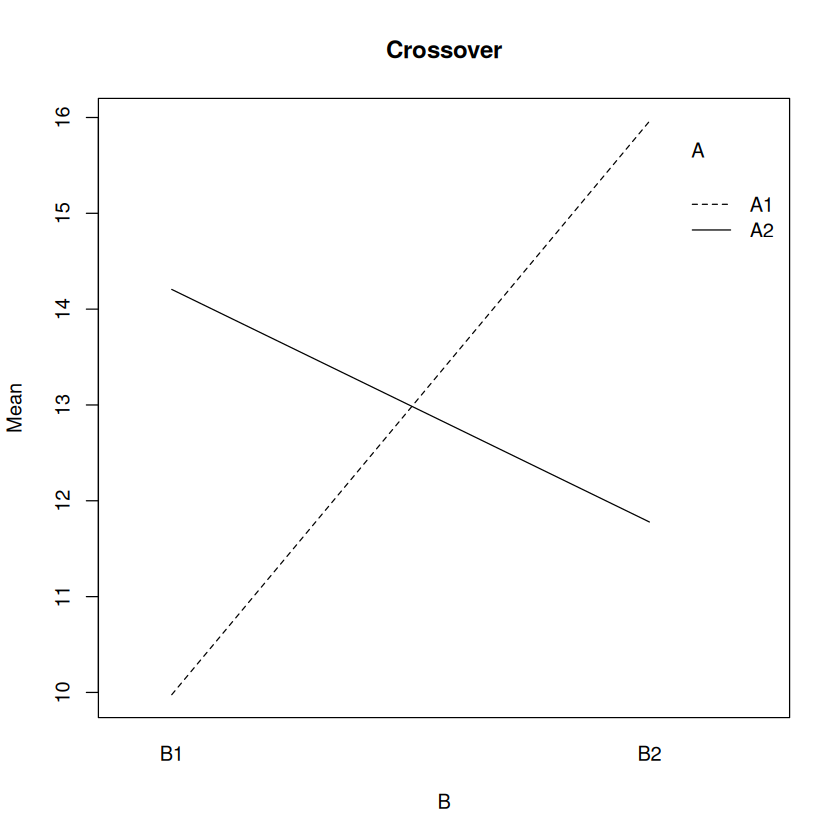

In [5]:
with(dat_x, interaction.plot(x.factor = B, trace.factor = A, response = y, ylab = "Mean", main = "Crossover"))

### Interactions as Multiplicative Effects
So, given what we have described above, how do we accommodate an interaction into the additive model? To see this most clearly, we will start from first principles in order to build-up what an interaction *actually* is. To do so, we will briefly return to a more traditional multiple regression model with two variables

$$
y_{i} = \beta_{0} + \beta_{1}x_{i1} + \beta_{2}x_{i2} + \epsilon_{i}.
$$

To make the logic easier to follow, we will rename $\beta_{2} \rightarrow \gamma$. This may seem unnecessarily confusing, but just stick with it for the moment. So, the model we are using has the form 

$$
y_{i} = \beta_{0} + \beta_{1}x_{i1} + \gamma x_{i2} + \epsilon_{i}.
$$

If it were the case that $x_{i1}$ and $x_{i2}$ were *dependent*, then the additive assumption fails and the effect associated with $x_{i2}$ (which we have named $\gamma$) is actually *related* to $x_{i1}$ in some fashion. We can write this dependence as *another* regression equation of the form

$$
\gamma = \beta_{2} + \beta_{3}x_{i1}.
$$

So, here, $\beta_{2}$ represents the part of the relationship between $x_{i2}$ and $y_{i}$ that is *independent* of $x_{i1}$, and $\beta_{3}$ represents the part of the relationship between $x_{i2}$ and $y_{i}$ that is *dependent* on $x_{i1}$. If we insert this new definition of $\gamma$ into the original regression equation, we get

$$
y_{i} = \beta_{0} + \beta_{1}x_{i1} + (\underbrace{\beta_{2} + \beta_{3}x_{i1}}_{\gamma})x_{i2} + \epsilon_{i}.
$$

If we now remove the brackets, we arrive at the final model

$$
y_{i} = \beta_{0} + \underbrace{\beta_{1}x_{i1} + \beta_{2}x_{i2}}_{\text{additive model}} + \underbrace{\beta_{3}x_{i1}x_{i2}}_{\text{interaction}} + \epsilon_{i}.
$$

So what is an interaction? In modelling terms, it is the effect associated with the *multiplication* of predictor variables[^interact-foot]. Hence, an interaction effect is often termed a *multiplicative* effect, rather than an *additive* effect. We will make the intuition behind this a little clearer below. First, let us look at the full factorial ANOVA model and how it can be expressed using dummy variables.

## The Full Factorial ANOVA
In terms of translating the regression model above into an ANOVA that contains an interaction term, we simply use a similar convention to previous models and express it as

$$
y_{ijk} = \mu + \alpha_{i} + \beta_{j} + (\alpha\beta)_{ij} + \epsilon_{ijk}.
$$

Here, we have simply taken the additive model and included an additional *interaction effect*, which is denoted $(\alpha\beta)_{ij}$. This makes it clear that this is the *multiplicative* effect of Factor A and Factor B. Indeed, we might typically refer to this as the $A \times B$ interaction effect.

In terms of how this works with dummy variables, let us examine the dummies for both `origin` and `vs`

In [6]:
X <- model.matrix(~ origin * vs, data=mtcars)
rownames(X) <- NULL
colnames(X) <- c("","origin   ","vs       ","origin*vs")
write.table(t(X[,2:3]), row.names=TRUE, col.names=FALSE, quote=FALSE)

origin    0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0
vs        1 1 0 0 1 0 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0


So, how do we add an interaction here? Well, given that an interaction is a *multiplicative* effect, we simply multiply the `origin` dummy and the `vs` dummy to give

In [7]:
write.table(t(X[,2:4]), row.names=TRUE, col.names=FALSE, quote=FALSE)

origin    0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0
vs        1 1 0 0 1 0 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0
origin*vs 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0


So, the interaction dummy variable will only have a value of `1` when `origin = 1` and `vs = 1`, otherwise it will have a value of `0`. Let us see what this does in terms of the definition of the cell means.

$$
\begin{alignat*}{4}
    \mu_{11} &= \beta_{0} + (\beta_{1} \times \mathbf{0}) + (\beta_{2} \times \mathbf{0}) &&+ (\beta_{3} \times \mathbf{0}) &&= \beta_{0} &&\quad\texttt{(Other,Straight)} \\
    \mu_{21} &= \beta_{0} + (\beta_{1} \times \mathbf{1}) + (\beta_{2} \times \mathbf{0}) &&+ (\beta_{3} \times \mathbf{0}) &&= \beta_{0} + \beta_{1} &&\quad\texttt{(USA,Straight)} \\
    \mu_{12} &= \beta_{0} + (\beta_{1} \times \mathbf{0}) + (\beta_{2} \times \mathbf{1}) &&+ (\beta_{3} \times \mathbf{0}) &&= \beta_{0} + \beta_{2} &&\quad\texttt{(Other,V-shaped)} \\
    \mu_{22} &= \beta_{0} + \underbrace{(\beta_{1} \times \mathbf{1})}_{\texttt{origin}} + \underbrace{(\beta_{2} \times \mathbf{1})}_{\texttt{vs}} &&+ \underbrace{(\beta_{3} \times \mathbf{1})}_{\texttt{origin * vs}} &&= \beta_{0} + \beta_{1} + \beta_{2} + \beta_{3} &&\quad\texttt{(USA,V-shaped)}\\
\end{alignat*}
$$

Here it is clear that the interaction effect itself is only added to the definition of $\mu_{22}$. We will provide a more complete explanation of this further below. For now, the intution is that that adding some extra flexibility to the definition of $\mu_{22}$ is all that is needed to lift the restrictions of the additive model. Indeed, it is the additive definition of $\mu_{22}$ that *creates* the restriction on the value of the other parameters. This is because this definition only works when there is a *contant* row and column effect. Adding another parameter here means that these constant effects are no longer necessary and the means can become whatever the fitting procedure wants them to be. In the case of least-squares/maximum likelihood, this will be the sample cell means.

```{admonition} Multiplication Intuition
:class: tip
It may not be immediately clear why multiplying two variables together would give you an interaction effect. The trick here is understanding that multiplying the values of two variables produces a *new* variable whose value combines the effect of both individual variables together. This can be thought of as *scaling* one variable by the other. In terms of two continuous predictors, think of the product $x_{i1}x_{i2}$ as a *modulator*. When $x_{i2} = 0$, the product term contributes *nothing*. As the value of $x_{i2}$ *increases*, the influence of $x_{i1}$ gets *amplified*. So, the interaction term acts like a scaling knob that adjusts one predictor’s slope depending on the other predictor’s level. In the context of *dummy variables*, this amplification only happens when $x_{i1} = 1$ *and* $x_{i2} = 1$. If either dummy is 0, then the interaction term does nothing. So, in this context, the interaction acts more like a *switch* that allows it to contribute that *little bit extra* to one cell of the design. This is all that is needed in order to allow the additive assumption to be lifted and for the estimated cell means to take on the same value as the sample means.
```

### The Full Factorial Model in `R`
In order to fit the full factorial model in `R`, we start with the additive model and then include an additional interaction effect. The syntax for an interaction between two predictors is `predictor1:predictor2`. Within the context of the `mtcars` dataset, an interaction between `origin` and `vs` can therefore be included using

In [8]:
fullfac.model <- lm(mpg ~ origin + vs + origin:vs, data=mtcars)
summary(fullfac.model)


Call:
lm(formula = mpg ~ origin + vs + origin:vs, data = mtcars)

Residuals:
   Min     1Q Median     3Q    Max 
-7.791 -3.031  0.200  2.050  8.309 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           25.5909     1.2693  20.161  < 2e-16 ***
originUSA             -4.8242     2.7421  -1.759  0.08945 .  
vsV-shaped            -6.6409     1.9562  -3.395  0.00207 ** 
originUSA:vsV-shaped   0.6242     3.3922   0.184  0.85532    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.21 on 28 degrees of freedom
Multiple R-squared:  0.5593,	Adjusted R-squared:  0.5121 
F-statistic: 11.84 on 3 and 28 DF,  p-value: 3.466e-05


Alternatively, we can use the `*` syntax to tell `R` to fit a full factorial model between multiple predictor variables. For instance, specifiying `origin*vs` will automatically expanded the model specification to include all main effects and interactions. This can be especially helpful when you have a big model and want to include eveything, though knowing how to specify all effects explicitly is important because there may be times where you want to *exclude* some interactions, but not all. As an example, the full factorial shorthand for this model would be

In [9]:
fullfac.model <- lm(mpg ~ origin*vs, data=mtcars)

In terms of the estimated cell means, we can use what we determined above to construct the estimates from this model

In [10]:
beta <- coef(fullfac.model)

# fitted cell means
mu.other.str <- beta[1]
mu.USA.str   <- beta[1] + beta[2]
mu.other.v   <- beta[1] + beta[3]
mu.USA.v     <- beta[1] + beta[2] + beta[3] + beta[4]

# means table
est.means.tbl <- data.frame("origin.other"=c(mu.other.str,mu.other.v),
                            "origin.USA"  =c(mu.USA.str,  mu.USA.v),
                            row.names=c("vs.straight","vs.vshaped"))

print(est.means.tbl)

            origin.other origin.USA
vs.straight     25.59091   20.76667
vs.vshaped      18.95000   14.75000


which now agree with the sample means we determined in the previous part of this lesson. As such, we can see that the full factorial model lifts the constraint of constant column effects and constant row effects, allowing the fitted means to match the sample means. Furthermore, we can calculate the interaction effect explicitly from the cell means

In [11]:
origin.x.vs <- (mu.other.str - mu.USA.str) - (mu.other.v - mu.USA.v)

print(unname(origin.x.vs))

[1] 0.6242424


Which is *precisely* the interaction effect given in the summary table above

In [12]:
print(unname(beta[4]))

[1] 0.6242424


As such, we can see directly that $\beta_{3} = (\mu_{11} - \mu_{21}) - (\mu_{12} - \mu_{22})$. So, the interaction term directly captures the difference of differences that both defines the interaction and which is assumed to be 0 under the additive model. We can also take this further to explore the deeper connection between interactions, cell means and the dummy variable model. This gets a bit involved and so we have included it as optional content in the drop-down below.


```{admonition} Connecting Interactions, Cell Means and Multiplying Dummy Variables
:class: dropdown
Having a more complete picture of the cell means in both the additive and full factorial models allows us to make a more explicit connection between the interaction effect as a comparison of cell means and the interaction effect as the multiplication of two dummy variables. This gets a bit complicated, hence why this information is *optional*. However, working through the logic below carefully will provide you with a more complete picture of how all this information fits together. 

Recall from our discussion of the parameters in the additive model that we can think of each additional parameter as providing a way from getting from our reference cell ($\mu_{11} = \beta_{0}$) to the other cells in the design. If we think about what we would need in order for the estimated cell means to equal the sample cell means, there is nothing inherently restrictive about defining $\beta_{0} = \mu_{11}$. Similarly, there is nothing to stop $\beta_{1}$ providing the exact difference needed to compute $\mu_{21} = \beta_{0} + \beta_{1}$, and nothing to stop $\beta_{2}$ providing the exact difference needed to compute $\mu_{12} = \beta_{0} + \beta_{2}$. So, all three of these cell means can, in principle, be any value we like. 

The core *restriction* of the additive model comes from defining $\mu_{22} = \beta_{0} + \beta_{1} + \beta_{2}$. The *only* way for this to work is to constrain the values of $\beta_{0}$, $\beta_{1}$ and $\beta_{2}$. So, it is the cell mean $\mu_{22}$ that is causing the problem. So how do we remove this restriction? We add another parameter so that $\mu_{22} = \beta_{0} + \beta_{1} + \beta_{2} + \beta_{3}$. This additional parameter provides the *flexibility* to allow $\beta_{0}$, $\beta_{1}$ and $\beta_{2}$ to be whatever they want to be. Whatever their sum happens to be, we can always reach $\mu_{22}$ by adding $\beta_{3} = \mu_{22} - (\beta_{0} + \beta_{1} + \beta_{2})$. Because of this, it is only the cell $\mu_{22}$ that needs the additional flexibility to release the constrain on all the parameters. This is why multiplying the two dummy variables creates what is effectively a *switch* that only codes for the cell $\mu_{22}$. This provides the minimum extra amount of flexibility to remove the additive assumptions. Because the additive assumption is effectively that $(\mu_{11} - \mu_{21}) - (\mu_{12} - \mu_{22}) = 0$, this additional flexibility is *exactly* the non-zero value of this comparisons. Hence why $(\mu_{11} - \mu_{21}) - (\mu_{12} - \mu_{22}) = \beta_{3}$. 

We can actually show this explicitly by substituting our definition of each cell mean from the models given earlier and calculating the interaction effect. In the full factorial model, we have

$$
\begin{alignat*}{1}
    (\mu_{11} - \mu_{21}) - (\mu_{12} - \mu_{22}) &= \left(\overbrace{\beta_{0}}^{\mu_{11}} - \overbrace{\left[\beta_{0} + \beta_{1}\right]}^{\mu_{21}}\right) - \left(\overbrace{\left[\beta_{0} + \beta_{2}\right]}^{\mu_{12}} - \overbrace{\left[\beta_{0} + \beta_{1} + \beta_{2} + \beta_{3}\right]}^{\mu_{22}}\right) \\
    &= \left(\beta_{0} - \beta_{0} - \beta_{1}\right) - \left(\beta_{0} + \beta_{2} - \beta_{0} - \beta_{1} - \beta_{2} - \beta_{3}\right) \\
    &= \beta_{1} - \beta_{1} + \beta_{3} \\
    &= \beta_{3}
\end{alignat*}
$$

So, the interaction effect is *exactly* the regression parameter $\beta_{3}$. However, in the additive model without the interaction term we have

$$
\begin{alignat*}{1}
    (\mu_{11} - \mu_{21}) - (\mu_{12} - \mu_{22}) &= \left(\overbrace{\beta_{0}}^{\mu_{11}} - \overbrace{\left[\beta_{0} + \beta_{1}\right]}^{\mu_{21}}\right) - \left(\overbrace{\left[\beta_{0} + \beta_{2}\right]}^{\mu_{12}} - \overbrace{\left[\beta_{0} + \beta_{1} + \beta_{2}\right]}^{\mu_{22}}\right) \\
    &= \left(\beta_{0} - \beta_{0} - \beta_{1}\right) - \left(\beta_{0} + \beta_{2} - \beta_{0} - \beta_{1} - \beta_{2}\right) \\
    &= \beta_{1} - \beta_{1} \\
    &= 0
\end{alignat*}
$$

So the interaction difference of differences is 0, which we know already because the additive model constrains the means to have equal row and column effects, thus their subtraction will always lead to 0.
```

## The Omnibus Interaction Effect
Given what we have stated above, in the `mtcars` example the interaction effect is only a single value captured by a single model parameter. As such, we could just use the $t$-test within the regression table to assess the significant of the interaction term. More generally though, if one (or more) of the interacting factors has $> 2$ levels, the interaction effect will be split across *multiple* dummy variables and thus will be represented by *multiple* model parameters. The number of parameters can be easily calculated using the number of dummy variables for each factor. If Factor A needs $(m - 1)$ dummy variables and Factor B needs $(n - 1)$ dummy variables, then we will need $(m - 1)(n - 1)$ dummies to represent the interaction. Only when $m = n = 2$ will this be equal to 1. As such, it is more typical to consider the *omnibus* interaction effect, as a direct analogue of the main effects tests from the previous part of this lesson.

Much like we saw with main effects, the omnibus interaction effect can be determined by a simple model comparison

$$
\begin{alignat*}{1}
    \mathcal{M}_{0} &: y_{ijk} = \mu + \alpha_{i} + \beta_{j} + \epsilon_{ijk} \\
    \mathcal{M}_{1} &: y_{ijk} = \mu + \alpha_{i} + \beta_{j} + (\alpha\beta)_{ij} + \epsilon_{ijk},
\end{alignat*}
$$

which is clearly just comparing the additive model to the full factorial model. We can therefore easily conduct this test using model comparisons and `anova()`

In [13]:
null.mod <- lm(mpg ~ origin + vs,             data=mtcars)
full.mod <- lm(mpg ~ origin + vs + origin:vs, data=mtcars) # OR mpg ~ origin * vs

print(anova(null.mod,full.mod))

Analysis of Variance Table

Model 1: mpg ~ origin + vs
Model 2: mpg ~ origin + vs + origin:vs
  Res.Df    RSS Df Sum of Sq      F Pr(>F)
1     29 496.86                           
2     28 496.26  1   0.60021 0.0339 0.8553


or by using `Anova()`

In [14]:
print(Anova(full.mod))

Anova Table (Type II tests)

Response: mpg
          Sum Sq Df F value    Pr(>F)    
origin    132.66  1  7.4848 0.0106777 *  
vs        287.20  1 16.2043 0.0003925 ***
origin:vs   0.60  1  0.0339 0.8553211    
Residuals 496.26 28                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Either way, we can see that the amount to which the residual sum-of-squares changes after including the interaction effect is very small. Indeed, $F < 1$, which suggests that the amount to which the interaction term improves the model fit is even smaller than we would expect from pure error. With $F = 0.03$, this indicates that the model explains only 3% as much variance as would be expected by noise alone[^Fsqrt-foot]. This is essentially *no effect* and would be considered unambiguously non-significant using the standards of NHST with $p = 0.855$. We can easily see this if we plot the effect 

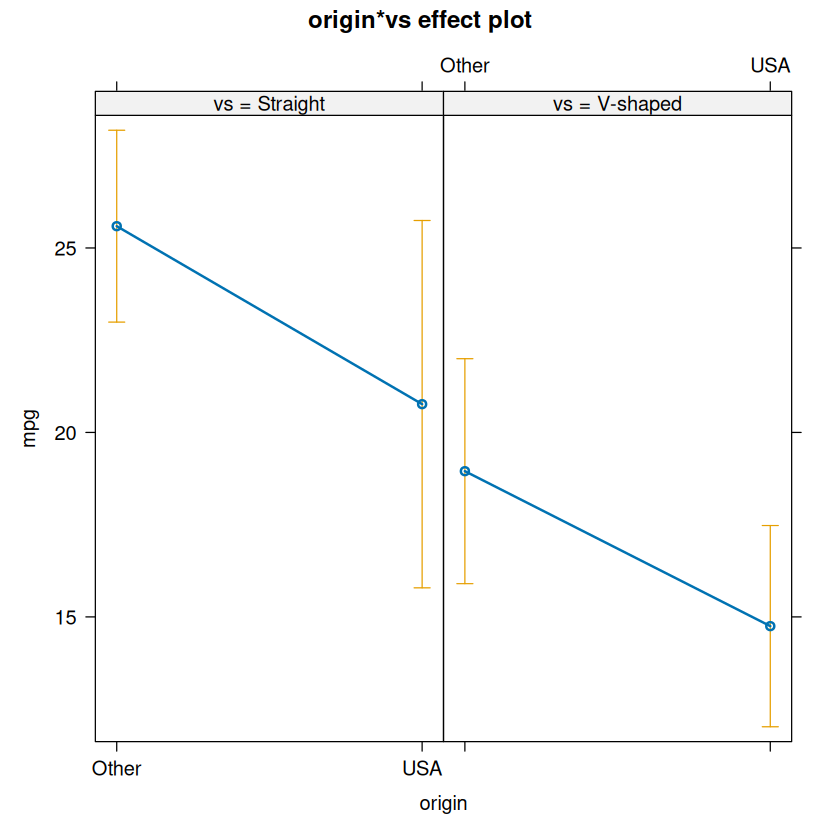

In [15]:
library(effects)
plot(effect("origin:vs", full.mod))

where it is clear that the two lines are basically parallel, for all practical purposes. As such, we would likely conclude that there is nothing about engine shape that informs where a car is manufactured, nor anything about where a car is manufacturered that influences the shape of its engine. In this case, it seems that the additive model is perfectly justified.

```{admonition} Removing the Interaction
:class: tip
It is worth noting that many statisticians would recommend removing non-significant interaction effects from the model before proceeding. This is not typically done in Psychology. Instead, due to the prevalence of NHST, these effects are simply assessed based on their significance and interpreted accordingly. This is largely because the focus of many statisticians is building the best model they can, whereas the focus in Psychology is largely about hypothesis tests. Indeed, as we have made clear across these various lessons, few Psychologists even think about ANOVAs in terms of models. So, with the result above, the statistician would go back to the additive model as the best representation of the data, whereas the psychologist would stick with the full factorial model and just interpret the hypothesis tests. Although the statistician's approach is generally a better exercise in *model building* (and a better approach generally), this distinction is important to know when looking at the psychological literature and working with psychologists who typically do not engage with such practices (particularly in the context of an ANOVA). 
```

## Main Effect in the Full Factorial Model
When the model contains interaction effects, we need to be more careful about how we define main effects.

...


For the purpose of illustration, we will alter the `mtcars` dataset to create an interaction between `origin` and `vs`. To do so, we add a constant to all the data within only a *single cell* and then rerun the model. The results are shown below.

Anova Table (Type II tests)

Response: mpg.fake
          Sum Sq Df F value    Pr(>F)    
origin    318.42  1 17.9662 0.0002209 ***
vs        855.82  1 48.2872 1.485e-07 ***
origin:vs  89.53  1  5.0517 0.0326650 *  
Residuals 496.26 28                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


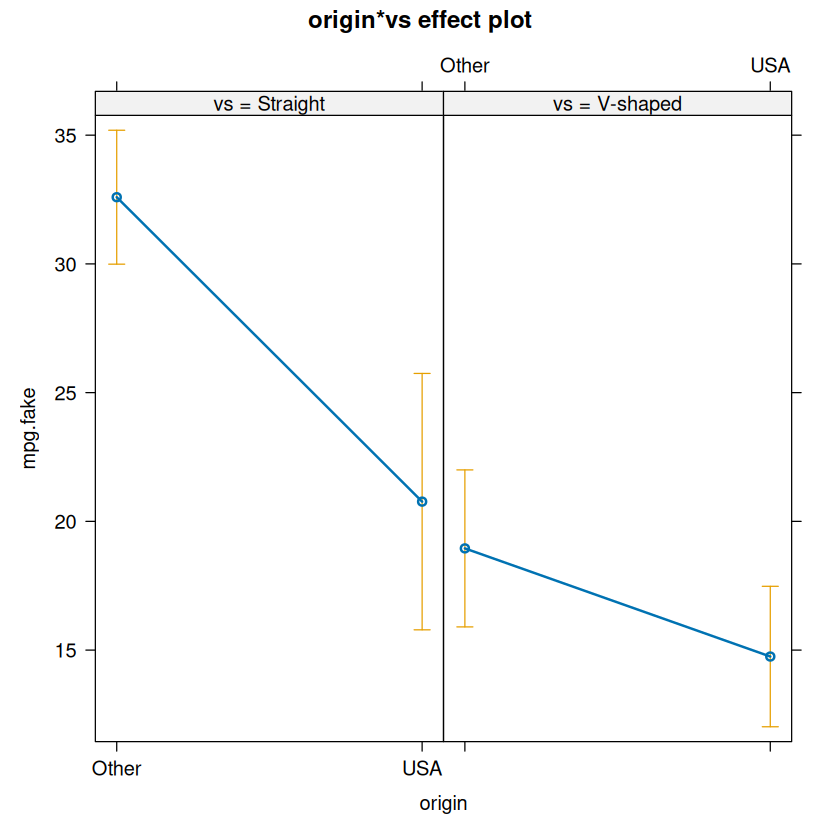

In [32]:
mpg.fake          <- mtcars$mpg                                         # copy mpg
mpg.idx           <- mtcars$origin == "Other" & mtcars$vs == "Straight" # index of Other-Straight cell
mpg.cell          <- mpg.fake[mpg.idx]                                  # data from that one cell
mpg.fake[mpg.idx] <- mpg.cell + 7                                       # add 7 to all data from that cell
mtcars$mpg.fake   <- mpg.fake                                           # save to dataset

fake.mod <- lm(mpg.fake ~ origin + vs + origin:vs, data=mtcars)
print(Anova(fake.mod))
plot(effect("origin:vs", mod=fake.mod))

Now, we have a (completely fake) two-way interaction. As we can see from the visualisation, this is a non-crossover interaction where the effect of `Straight` vs `V-shaped` differs between the `USA` and `Other` countries of origin.

### Interpreting Main Effects in the Presence of an Interaction
Under additivity, the differences between the marginal means are *identical* to the constant row or column difference and thus directly capture the overall differences between the levels of a single factor, irrespective or the levels of the other factors in the model. When additivity does not hold, this logic breaks down as the marginal means may not longer capture any effects that reflect the actual data. We will see this later when we discuss *interactions*.

### Type II Effects

This gets a little tricky, but we will discuss more about Type I, Type II and Type III tests in the final lesson on this unit. For now, just know that Type II main effects are calculated based on assuming that the interaction effect is 0. In other words, they are calculated as if the additive model were true[^type2-foot]. 

Why would we want to do this? Well, consider the two situations we may find ourselves in:

1. The interaction effect is significant
    - In this case, we know that the main effects are not meaningful and so should be ignored anyway. We would simply focus on the interaction effect and interpret it.
2. The interaction effect is *not* significant
    - In this case, the additive model is the most suitable and we should interpret main effects as if the additive model were true.

As we can see, the Type II tests allow for both these situations. If the interaction is significant, the main effects are meaningless anyway so should be ignored. If the interaction is non-significant, the additive model is preferred and the Type II main effects are then the form that we want.

In [18]:
# Numerator from ADDITIVE MODELS
null.mod <- lm(mpg ~ vs,          data=mtcars)
full.mod <- lm(mpg ~ origin + vs, data=mtcars)
null.RSS <- sum(resid(null.mod)^2)
full.RSS <- sum(resid(full.mod)^2)
SS.B     <- null.RSS - full.RSS

# Denominator from FULL FACTORIAL MODEL
full.mod.2 <- lm(mpg ~ origin + vs + origin:vs, data=mtcars)
SS.W       <- sum(resid(full.mod.2)^2)

# Mean-squares
df.1 <- 1                      # k - 1
df.2 <- full.mod.2$df.residual # n - p
MS.B <- SS.B / df.1            # reduction in error variance (effect)
MS.W <- SS.W / df.2            # remaining error variance (error)

# F-ratio
F <- MS.B / MS.W

# p-value from null F-distribution with df1 and df2
p <- pf(q=F, df1=df.1, df2=df.2, lower.tail=FALSE)

# Results
print(data.frame("F.ratio"=F, "p.value"=p), row.names=FALSE)

  F.ratio    p.value
 7.484841 0.01067766


### Interpreting Main Effects in the Presence of an Interaction
... We can see that averaging over either the rows or columns of the means table only makes sense when additivity is assumed. If we do this when there is not a constant row or column effect, the very meaning of the main effect breaks down. If we want to think of a main effect as the consistent effect of a factor irrespective of other factors, this is no longer valid when those effects are *not* consistent. As such, main effects must assume additivity to make any sense. If there is a large interaction effect, the very concept of a main effects no longer make sense. 

Indeed, you do not need to know anything about the model to see this. The interaction tells us that the main effect depends upon the level of another factor. Why would we then try to look at a main effect *ignoring* that factor? We know that other factor matters. That is what the interaction tells us. Unfortuantely, it is common practise in Psychology to ignore this and try to interpret main effects in the presence of significant interactions. Hopefully it is clear how meaningless this actually is.

[^type2-foot]: Note that these tests are not identical to simply fitting an additive model, but this is a subtlety we will leave to one side for now.

[^round-foot]: We use the `round()` function here because the way that `lm()` solves for the model parameters can introduce differences between identical predictions ways down at the 15th decimal. We would not normally notice these, but the `unique()` function will and will return apparently identical estimates, claiming they are different.

[^interact-foot]: This does imply that interactions can occur between *any* variables, and indeed they can. We can have continuous $\times$ continuous, categorical $\times$ continuous, and categroical $\times$ categorical interactions. 

[^crosspower-foot]: This is simply because one of the mean differences is negative and one is postitive. If we subtract a positive and negative number, the signs cancel and the effects *sum*. So, a perfect crossover would be something like $(10 - 5) - (5 - 10) = 5 - (-5) = 5 + 5 = 10$. A non-crossover would then be something like $(10 - 5) - (6 - 5) = 5 - 1 = 4$. So the effect is much smaller.

[^Fsqrt-foot]: If you find it difficult conceptualising magnitudes in terms of variances, you can always re-express an $F$ in standard deviation terms by taking $t = \sqrt{F}$. You can then interpret $F$ in standard deviation terms, exactly like the $t$-statistic. However, it is important to note that this only works when $df_{1} = 1$. When $df_{1} > 1$, there is no such clear analogue. 